In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import PIL
from PIL import Image # This line already imports Image correctly.
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hashbanger_ph2_resized2_path = kagglehub.dataset_download('hashbanger/ph2-resized2')
print(hashbanger_ph2_resized2_path)
print('Data source import complete.')

!cd /root/.cache/kagglehub/datasets/hashbanger/ph2-resized2/versions/1 && ls

/root/.cache/kagglehub/datasets/hashbanger/ph2-resized2/versions/1
Data source import complete.
ph2_resized2  trainx  trainy


In [ ]:
def load_data(image_dir, mask_dir):
    images, masks = [], []
    file_names = sorted(os.listdir(image_dir))
    for file_name in file_names:
        image_path = os.path.join(image_dir, file_name)
        mask_file_name = file_name.replace("X_img", "Y_img")
        mask_path = os.path.join(mask_dir, mask_file_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(180, 180), color_mode='grayscale')
            images.append(tf.keras.preprocessing.image.img_to_array(image) / 255.0)
            masks.append(tf.keras.preprocessing.image.img_to_array(mask) / 255.0)
        else:
            print(f"Eksik dosya: {file_name} veya {mask_file_name}")
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/ph2/trainx_rs"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/ph2/trainy_rs"
X, Y = load_data(image_dir, mask_dir)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (160, 180, 180, 3)
x_test shape: (40, 180, 180, 3)
y_train shape: (160, 180, 180, 1)
y_test shape: (40, 180, 180, 1)


In [ ]:
def unet_model():
    inputs = layers.Input((180, 180, 3))

    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    u2 = layers.UpSampling2D((2, 2))(p2)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u3 = layers.UpSampling2D((2, 2))(c3)
    u3 = layers.Concatenate()([u3, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 180, 180, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 180, 180, 32)   │          9,248 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 90, 90, 32)     │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 90, 90, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 90, 90, 64)     │         36,928 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 45, 45, 64)     │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 90, 90, 64)     │              0 │ max_pooling2d_3[0][0]  │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 90, 90, 128)    │              0 │ up_sampling2d_2[0][0], │
│ (Concatenate)             │                        │                │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 90, 90, 64)     │         73,792 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 90, 90, 64)     │         36,928 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 180, 180, 64)   │              0 │ conv2d_14[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 180, 180, 96)   │              0 │ up_sampling2d_3[0][0], │
│ (Concatenate)             │                        │                │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 180, 180, 32)   │         27,680 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 180, 180, 32)   │          9,248 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 180, 180, 1)    │             33 │ conv2d_16[0][0]        │
└──────────────────────

 Total params: 213,249 (833.00 KB)

 Trainable params: 213,249 (833.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), batch_size=8)

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9595 - loss: 0.1037 - val_accuracy: 0.9435 - val_loss: 0.1547
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9556 - loss: 0.1127 - val_accuracy: 0.9411 - val_loss: 0.1657
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9605 - loss: 0.0991 - val_accuracy: 0.9405 - val_loss: 0.1744
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9570 - loss: 0.1090 - val_accuracy: 0.9423 - val_loss: 0.1653
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9603 - loss: 0.1019 - val_accuracy: 0.9311 - val_loss: 0.1964
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9498 - loss: 0.1248 - val_accuracy: 0.9356 - val_loss: 0.1928
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9607 - loss: 0.1026 - val_accuracy: 0.9399 - val_loss: 0.1587
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9556 - loss: 0.1163 - val_accu

In [ ]:
model.save('unet_model.keras')
print("Model kaydedildi.")

Model kaydedildi.


In [ ]:
def display_results(model, X_samples, Y_samples, threshold=0.6):
    predictions = model.predict(X_samples)
    plt.figure(figsize=(15, 5))

    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.title("Orijinal")
        plt.imshow(X_samples[i])
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.title("Ground Truth")
        plt.imshow(Y_samples[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Eşikleme işlemi
        binary_prediction = (predictions[i] > threshold).astype(np.uint8)
        plt.subplot(3, 3, i * 3 + 3)
        plt.title("Tahmin (Binary)")
        plt.imshow(binary_prediction.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Kayıp: {loss:.4f}, Test Doğruluk: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9420 - loss: 0.5287
Test Kayıp: 0.5475, Test Doğruluk: 0.9414


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


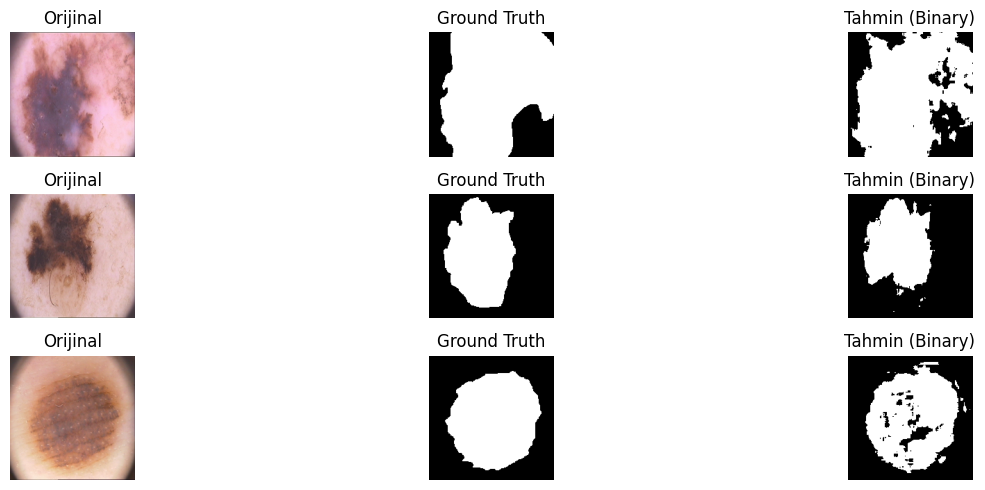

In [ ]:
display_results(model, x_test ,y_test)

In [ ]:
# F1 Skorunu Hesaplama Fonksiyonu
def calculate_f1_score(model, X_test, Y_test, threshold=0.4):
    predictions = model.predict(X_test)
    binary_predictions = (predictions > threshold).astype(np.uint8)
    f1 = f1_score(Y_test.flatten(), binary_predictions.flatten())
    print(f"F1 Skoru: {f1:.4f}")
calculate_f1_score(model, x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Skoru: 0.9161
